# HMM on the CAMCAN dataset from Chet

### There are 12 subjects - eyes closed

In [1]:
from osl_dynamics.data import Data
import numpy as np
import seaborn as sns
import os

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

/opt/anaconda3/envs/osld/lib/python3.12/site-packages/osl_dynamics/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Import the data

In [2]:
from glob import glob

all_files = sorted(glob("sub-*_sflip_parc-raw.fif"))
data = Data(all_files, picks="misc", reject_by_annotation="omit")

Loading files:   0%|          | 0/12 [00:00<?, ?it/s]

In [3]:
for x in data.time_series():
    print(x.shape)
    

(122000, 52)
(130750, 52)
(133000, 52)
(132500, 52)
(136750, 52)
(133000, 52)
(132750, 52)
(142500, 52)
(133250, 52)
(132750, 52)
(131750, 52)
(132000, 52)


## TDE + Standardise

In [4]:
data.tde_pca(n_embeddings=15, n_pca_components=80)

Calculating PCA components:   0%|          | 0/12 [00:00<?, ?it/s]

2025-07-15 10:44:26 INFO osl-dynamics [base.py:853:tde_pca]: Explained variance: 48.7%


TDE-PCA:   0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
data.standardize()


Standardize:   0%|          | 0/12 [00:00<?, ?it/s]

## Setup and run HMM

In [6]:
from osl_dynamics.models.hmm import Config, Model

config = Config(
    n_states=8,
    n_channels=data.n_channels,
    sequence_length=200,
    learn_means=False,
    learn_covariances=True,
    batch_size=128,
    learning_rate=0.01,
    n_epochs=20,
)
model = Model(config)

In [7]:
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 200, 80)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (8, 80)           │        640 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (8, 80, 80)       │     25,920 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 200, 80)   │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 200, 80), │         72 │ ll[0][0]          │
│ (HiddenMarkovState… │ (None, 200, 8,    │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ hid_state_inf[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,632 (104.03 KB)

 Trainable params: 25,992 (101.53 KB)

 Non-trainable params: 640 (2.50 KB)

In [8]:
init_history = model.random_state_time_course_initialization(data, n_init=3, n_epochs=1)


2025-07-15 10:44:40 INFO osl-dynamics [inf_mod_base.py:1416:random_state_time_course_initialization]: Random state time course initialization
2025-07-15 10:44:40 INFO osl-dynamics [inf_mod_base.py:1432:random_state_time_course_initialization]: Initialization 0
2025-07-15 10:44:40 INFO osl-dynamics [inf_mod_base.py:1472:set_random_state_time_course_initialization]: Setting random means and covariances
2025-07-15 10:44:43.268347: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 988ms/step - ll_loss: 111.8808 - loss: 111.8376 - learning_rate: 0.0100 - rho: 0.2853


2025-07-15 10:45:49 INFO osl-dynamics [inf_mod_base.py:1432:random_state_time_course_initialization]: Initialization 1
2025-07-15 10:45:49 INFO osl-dynamics [inf_mod_base.py:1472:set_random_state_time_course_initialization]: Setting random means and covariances
2025-07-15 10:45:52.065823: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 967ms/step - ll_loss: 111.8335 - loss: 111.8500 - learning_rate: 0.0100 - rho: 0.2853


2025-07-15 10:46:55 INFO osl-dynamics [inf_mod_base.py:1432:random_state_time_course_initialization]: Initialization 2
2025-07-15 10:46:55 INFO osl-dynamics [inf_mod_base.py:1472:set_random_state_time_course_initialization]: Setting random means and covariances


63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 975ms/step - ll_loss: 111.8987 - loss: 111.8999 - learning_rate: 0.0100 - rho: 0.2853


2025-07-15 10:48:01 INFO osl-dynamics [inf_mod_base.py:1458:random_state_time_course_initialization]: Using initialization 2


In [9]:
history = model.fit(data)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - ll_loss: 110.5821 - loss: 110.6128 - learning_rate: 0.0100 - rho: 0.2853
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - ll_loss: 110.7238 - loss: 110.6608 - learning_rate: 0.0090 - rho: 0.1866
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - ll_loss: 110.4663 - loss: 110.4665 - learning_rate: 0.0082 - rho: 0.1436
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - ll_loss: 110.3687 - loss: 110.3188 - learning_rate: 0.0074 - rho: 0.1187
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - ll_loss: 110.5364 - loss: 110.5126 - learning_rate: 0.0067 - rho: 0.1022
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - ll_loss: 110.2878 - loss: 110.2937 - learning_rate: 0.0061 - rho: 0.0904
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - ll_loss: 110.1831 - loss: 110.2166 - learning_rate: 0.0055 - rho: 0.0814
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - ll_loss: 110.1737 - loss: 110.1648 - learning_rate: 0.0050 - rho: 0.0743


In [10]:
model.save("results/model")


In [11]:
from osl_dynamics.models import load
model = load("results/model")

2025-07-15 11:16:53 INFO osl-dynamics [mod_base.py:794:load]: Loading model: results/model


## Post HMM Stuff

In [12]:
import numpy as np
import os
import pickle

inf_params_dir = "results/inf_params"
os.makedirs(inf_params_dir, exist_ok=True)

alpha = model.get_alpha(data)
means = model.get_means()
covs = model.get_covariances()
trans_prob = model.get_trans_prob()
initial_state_probs = model.get_initial_state_probs()

pickle.dump(alpha, open(f"{inf_params_dir}/alp.pkl", "wb"))
np.save(f"{inf_params_dir}/means.npy", means)
np.save(f"{inf_params_dir}/covs.npy", covs)
np.save(f"{inf_params_dir}/trans_prob.npy", trans_prob)
np.save(f"{inf_params_dir}/initial_state_probs.npy", initial_state_probs)

Getting alpha:   0%|          | 0/12 [00:00<?, ?it/s]

## Check the state time-courses look reasonable - no one state per participant

In [13]:
viterbi_path = model.get_viterbi_path(data)


Getting Viterbi path:   0%|          | 0/12 [00:00<?, ?it/s]

2025-07-15 11:17:59.842959: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-15 11:18:03.274079: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(<Figure size 1200x250 with 2 Axes>, [<Axes: xlabel='Time (s)'>])

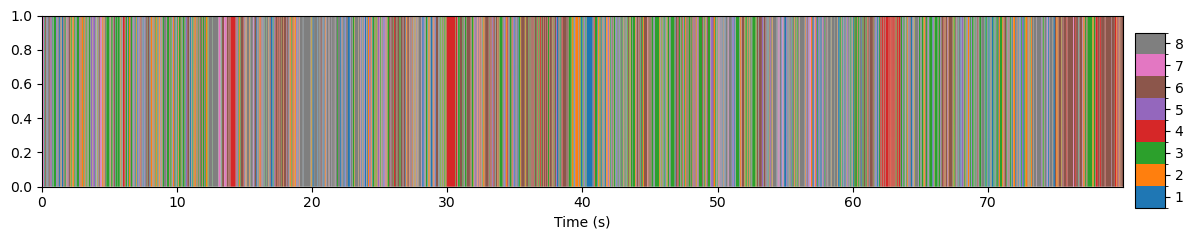

In [14]:
from osl_dynamics.utils import plotting

plotting.plot_alpha(
    viterbi_path[10],
    n_samples=20000,
    sampling_frequency=250,
)

In [15]:
from osl_dynamics.inference import modes

# Hard classify the state probabilities
stc = modes.argmax_time_courses(alpha)

# Calculate fractional occupancies
fo = modes.fractional_occupancies(stc)
print(fo.shape)

(12, 8)


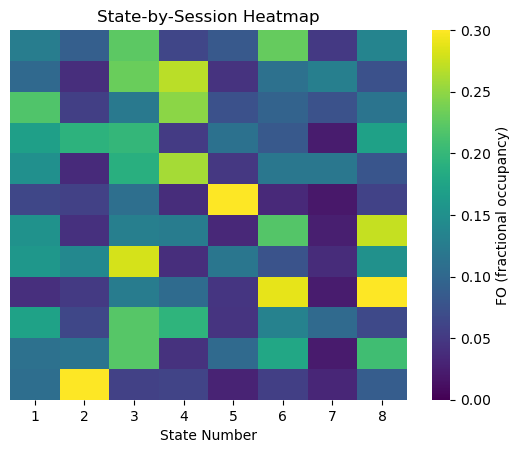

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap and capture the AxesImage to modify colorbar
ax = sns.heatmap(fo, cmap="viridis", vmin=0, vmax=0.3, cbar=True)

# Label the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label("FO (fractional occupancy)")

# Add horizontal white lines every 16 rows
for y in range(16, fo.shape[0], 16):
    plt.axhline(y=y, color='white', linewidth=2)

# Remove y-axis labels and ticks
plt.yticks([])

# Set dynamic x-axis labels
plt.xticks(ticks=np.arange(fo.shape[1]) + 0.5, labels=np.arange(1, fo.shape[1] + 1), rotation=0)

# Set x-axis title
plt.xlabel("State Number")

# Add plot title
plt.title("State-by-Session Heatmap")

# Save the figure
# plt.savefig('HMM_FO_6_state_problem.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## Reload the data without embedding!

In [17]:
from glob import glob

all_files = sorted(glob("sub-*_sflip_parc-raw.fif"))
data = Data(all_files, picks="misc", reject_by_annotation="omit")

Loading files:   0%|          | 0/12 [00:00<?, ?it/s]

## Reload the results

In [18]:
import pickle
import numpy as np

# Define your directory
inf_params_dir = "results/inf_params"

# Load the variables
alpha = pickle.load(open(f"{inf_params_dir}/alp.pkl", "rb"))
means = np.load(f"{inf_params_dir}/means.npy")
covs = np.load(f"{inf_params_dir}/covs.npy")
trans_prob = np.load(f"{inf_params_dir}/trans_prob.npy")
initial_state_probs = np.load(f"{inf_params_dir}/initial_state_probs.npy")

## Trim the data

In [19]:
trimmed_data = data.trim_time_series(n_embeddings=15, sequence_length=200)  # needs to match values used to prepare the data and build the model

for a, x in zip(alpha, trimmed_data):
    print(a.shape, x.shape)

(121800, 8) (121800, 52)
(130600, 8) (130600, 52)
(132800, 8) (132800, 52)
(132400, 8) (132400, 52)
(136600, 8) (136600, 52)
(132800, 8) (132800, 52)
(132600, 8) (132600, 52)
(142400, 8) (142400, 52)
(133200, 8) (133200, 52)
(132600, 8) (132600, 52)
(131600, 8) (131600, 52)
(131800, 8) (131800, 52)


## Multitaper Spectra

In [20]:
from osl_dynamics.analysis import spectral

# Calculate multitaper spectra for each state and subject (will take a few minutes)
f, psd, coh, w = spectral.multitaper_spectra(
    data=trimmed_data,
    alpha=alpha,
    sampling_frequency=250,
    frequency_range=[1, 45],
    return_weights=True,
)

Calculating spectra:   0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
import os

os.makedirs("results/spectra", exist_ok=True)
np.save("results/spectra/f.npy", f)
np.save("results/spectra/psd.npy", psd)
np.save("results/spectra/coh.npy", coh)
np.save("results/spectra/w.npy", w)

## Plot each PSD separately alongside mean PSD

(8, 88)


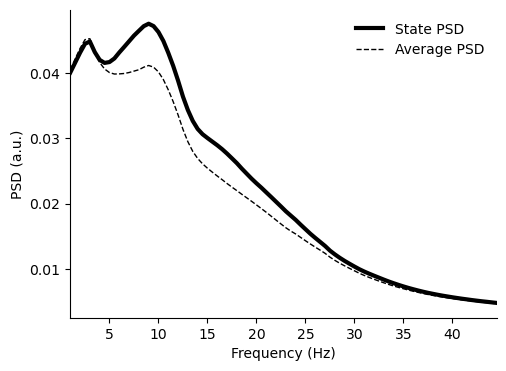

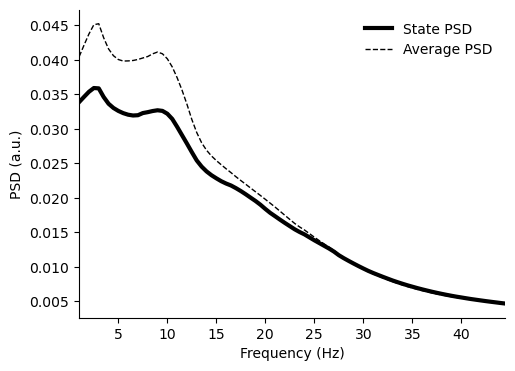

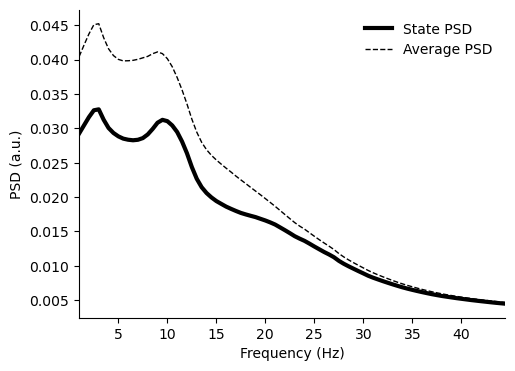

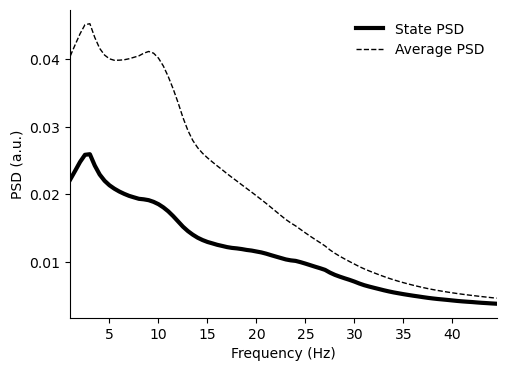

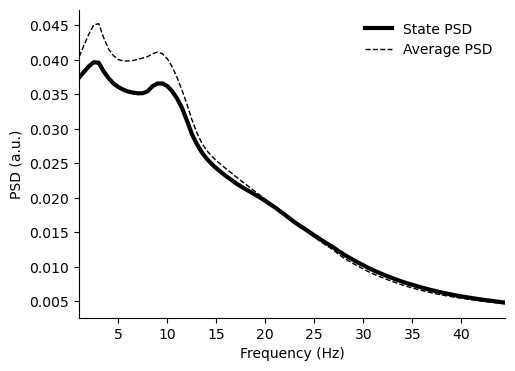

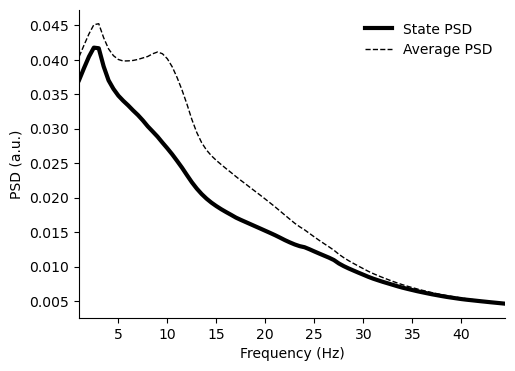

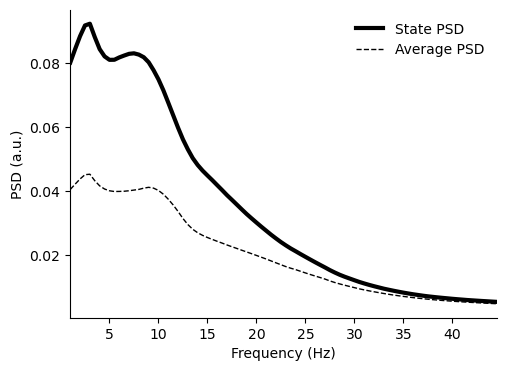

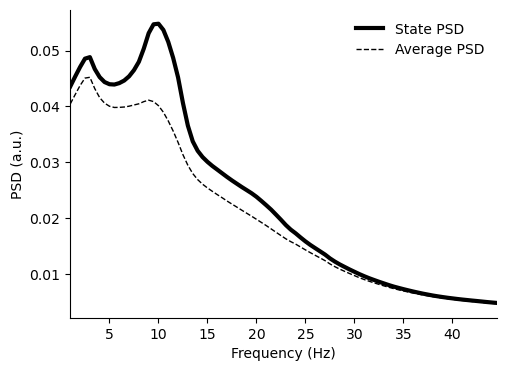

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from osl_dynamics.utils import plotting

# Average over subjects and channels
gpsd = np.average(psd, axis=0, weights=w)
psd_mean = np.mean(gpsd, axis=1)  # shape: (n_states, n_freqs)

print(psd_mean.shape)  # (n_states, n_freqs)

# Calculate overall mean across states for overlay
overall_mean = np.mean(psd_mean, axis=0)

n_states = psd_mean.shape[0]

# Loop over states to plot individually
for i in range(n_states):
    # Create figure and axis with desired size
    fig, ax = plt.subplots(figsize=(5.5, 4))
    
    # Plot state line
    state_line, = ax.plot(f, psd_mean[i], linewidth=3, linestyle='-', color='black', label='State PSD')
    
    # Plot overall mean line
    avg_line, = ax.plot(f, overall_mean, linewidth=1, linestyle='--', color='black', label='Average PSD')
    
    # Labels
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("PSD (a.u.)")
    ax.set_xlim([f[0], f[-1]])
    
    # Add legend without box
    legend = ax.legend(frameon=False)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save figure
    fig.savefig(f"PSD_state_{i}.png",bbox_inches='tight')
    plt.show()
    plt.close(fig)  # Close to free memory


## Now plot the whole-brain maps

In [23]:
from osl_dynamics.analysis import power

p = power.variance_from_spectra(f, psd)
print(p.shape)

p_mean = np.average(p, axis=0, weights=w)
print(p_mean.shape)

(12, 8, 52)
(8, 52)


In [24]:
# Takes a few seconds for the power maps to appear
power.save(
    p_mean,
    mask_file="MNI152_T1_8mm_brain.nii.gz",
    parcellation_file="Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz",
    filename = 'states_HMM.png',
    subtract_mean=True,  # just for visualisation
    plot_kwargs={
        "cmap": "Spectral_r",
        # "bg_on_data": 1,
        "symmetric_cbar": True,
        "views": ['lateral', 'medial']
    },
)

Saving images:   0%|          | 0/8 [00:00<?, ?it/s]

## Coherence

In [25]:
print(coh.shape)

from osl_dynamics.analysis import connectivity

c = connectivity.mean_coherence_from_spectra(f, coh)
print(c.shape)

mean_c = np.average(c, axis=0, weights=w)
print(mean_c.shape)


(12, 8, 52, 52, 88)
(12, 8, 52, 52)
(8, 52, 52)


## Threshold and plot

In [26]:
thres_mean_c = connectivity.threshold(mean_c, percentile=97, absolute_value=True)
print(thres_mean_c.shape)

connectivity.save(
    thres_mean_c,
    parcellation_file="Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz",
    component=0,
    filename='HMM_connectivity_'
)

(8, 52, 52)


Saving images:   0%|          | 0/8 [00:00<?, ?it/s]

## NNMF

2025-07-15 11:33:42 INFO osl-dynamics [spectral.py:1080:decompose_spectra]: Performing spectral decomposition


(2, 88)


(<Figure size 700x400 with 1 Axes>,
 <Axes: xlabel='Frequency (Hz)', ylabel='Spectral Component'>)

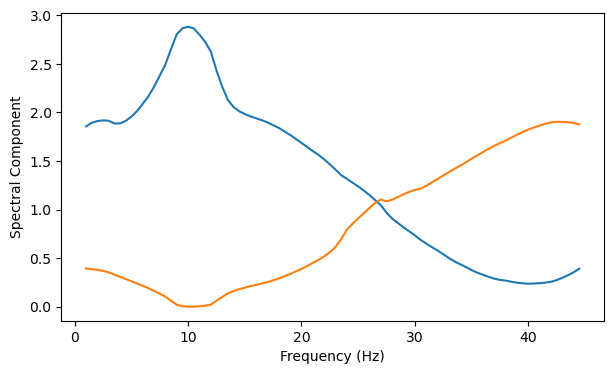

In [28]:
from osl_dynamics.analysis import spectral

# Perform NNMF on the coherence spectra of each subject (we concatenate each matrix)
wb_comp = spectral.decompose_spectra(coh, n_components=2)
print(wb_comp.shape)

from osl_dynamics.utils import plotting

plotting.plot_line(
    [f, f],  # we need to repeat twice because we fitted two components
    wb_comp,
    x_label="Frequency (Hz)",
    y_label="Spectral Component",
)

In [29]:
# Calculate the coherence network for each state by weighting with the spectral components
c = connectivity.mean_coherence_from_spectra(f, coh, wb_comp)
print(c.shape)

# Average over subjects
mean_c = np.average(c, axis=0, weights=w)
print(mean_c.shape)

# Threshold each network and look for the top 3% of connections relative to the mean
mean_c -= np.mean(mean_c, axis=0, keepdims=True)
thres_mean_c = connectivity.threshold(mean_c, percentile=95, absolute_value=True)
print(thres_mean_c.shape)

(12, 2, 8, 52, 52)
(2, 8, 52, 52)
(2, 8, 52, 52)


In [30]:
connectivity.save(
    thres_mean_c,
    parcellation_file="Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz",
    component=0,
    filename='HMM_connectivity_NNMF',
    plot_kwargs={
        "edge_cmap": "Spectral_r",
        # "bg_on_data": 1,
        # "darkness": 0.4,
        # "alpha": 1,
        #"symmetric_cbar": True
    },
)

Saving images:   0%|          | 0/8 [00:00<?, ?it/s]

## Coherence vs Power

In [31]:
import numpy as np

f = np.load("results/spectra/f.npy")
psd = np.load("results/spectra/psd.npy")
coh = np.load("results/spectra/coh.npy")
w = np.load("results/spectra/w.npy")

In [32]:
psd_2 = psd.mean(axis=1)

# Calculate power
p = power.variance_from_spectra(f, psd_2, wb_comp)
print(p.shape)

# Calculate coherence
c = connectivity.mean_coherence_from_spectra(f, coh, wb_comp)
print(c.shape)

(2, 12, 52)
(12, 2, 8, 52, 52)


In [33]:
# Average power over subjects
mean_p = np.mean(p, axis=0)
print(mean_p.shape)

# Average coherence over subjects
mean_c = np.mean(c, axis=0)
print(mean_c.shape)

# Keep the first spectral component
mean_p = mean_p[0]
mean_c = mean_c[0]
print(mean_p.shape)
print(mean_c.shape)

(12, 52)
(2, 8, 52, 52)
(52,)
(8, 52, 52)


In [34]:
mean_c = connectivity.mean_connections(mean_c)
print(mean_c.shape)

(8, 52)


In [35]:
fig, ax = plotting.plot_scatter(
    mean_p,
    mean_c,
    labels=[f"State {i}" for i in range(1, mean_p.shape[0] + 1)],
    x_label="Power (a.u.)",
    y_label="Coherence",
)

ValueError: Different number of x and y arrays given.

### Combine into nice images to share

In [36]:
from PIL import Image, ImageDraw, ImageFont

for i in range(8):
    # Filenames
    fn1 = f"states_HMM{i}.png"
    fn2 = f"PSD_state_{i}.png"
    fn3 = f"HMM_connectivity_NNMF{i}.png"
    
    # Open images
    im1 = Image.open(fn1)
    im2 = Image.open(fn2)
    im3 = Image.open(fn3)
    
    # Resize to match widths if needed
    width = max(im1.width, im2.width, im3.width)
    ims = []
    for im in [im1, im2, im3]:
        if im.width != width:
            new_height = int(im.height * (width / im.width))
            im = im.resize((width, new_height), Image.LANCZOS)
        ims.append(im)
    
    # Title bar height (adjusted for font size)
    title_height = 120
    
    # Total height including title bar
    total_height = title_height + sum(im.height for im in ims)
    
    # Create new blank image with white background for title bar and images
    combined = Image.new('RGB', (width, total_height), color='white')
    
    draw = ImageDraw.Draw(combined)
    title_text = f"State {i+1}"
    
    # Load font with size 100, fallback prints 'EXCEPTION'
    try:
        font_size = 70
        font = ImageFont.truetype("/Library/Fonts/Arial.ttf", font_size)
    except IOError:
        print("EXCEPTION: Arial font not found, using default font.")
        font = ImageFont.load_default()
        font_size = 70  # Keep size for layout calc, though default font ignores it
    
    # Get bounding box to center text horizontally and vertically in title bar
    bbox = draw.textbbox((0, 0), title_text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    text_x = (width - text_width) // 2
    text_y = (title_height - text_height) // 2
    
    # Draw title text in black
    draw.text((text_x, text_y), title_text, fill='black', font=font)
    
    # Paste images below the title bar
    y_offset = title_height
    for im in ims:
        combined.paste(im, (0, y_offset))
        y_offset += im.height
    
    # Save combined image
    combined.save(f"combined_state_{i}.png")
